code written on 15 April 2024 and refined on 23,25 May 

### **Import** **packages**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

### **Load** **Data**

* https://phoenixnap.com/kb/python-change-directory
* https://stackoverflow.com/questions/67112343/pathlib-vs-os-path-join-in-python

In [ ]:
os.getcwd()

In [6]:
# # URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'  #only train and validate data present
# path_to_folder = tf.keras.utils.get_file('dogs-vs-cats', origin='D:/Abhishek\ x360/Coding/PythonCode/Deep\ Learning\ Chollet')
# print(path_to_folder)
# PATH = os.path.join(os.path.dirname(path_to_folder), 'dogs-vs-cats')
# print(PATH)
PATH = os.path.join('D:\Abhishek x360\Coding\PythonCode\Deep Learning Chollet\dogs-vs-cats')
os.listdir(PATH)

['test', 'train']

In [21]:
os.chdir(PATH)

In [23]:
os.getcwd()

'D:\\Abhishek x360\\Coding\\PythonCode\\Deep Learning Chollet'

In [ ]:
train = os.path.join(PATH, 'train','train')
print(train)
test = os.path.join(PATH, 'test')
print(test)

In [ ]:
os.chdir(train)
os.getcwd()

In [9]:
print(len(os.listdir(train)))

25002


**Understand`** **the** **data**
Let's look at how many cats and dogs images are in the training and validation directory:

### creating datasets

In [10]:
os.getcwd()

'D:\\Abhishek x360\\Coding\\PythonCode\\Deep Learning Chollet\\dogs-vs-cats\\train\\train'

In [13]:
import os, shutil, pathlib
  
original_dir = train #pathlib.Path("train")                           
new_base_dir = pathlib.Path("cats_vs_dogs_small")              
 
def make_subset(subset_name, start_index, end_index):          
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
       
        fnames = [f"{category}.{i}.jpg" 
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src= os.path.join(original_dir, fname),
                            dst= os.path.join(dir, fname))
  
make_subset("train", start_index=0, end_index=1000)            
make_subset("validation", start_index=1001, end_index=1500)    
make_subset("test", start_index=1501, end_index=2500)  

In [15]:
new_base_dir

WindowsPath('cats_vs_dogs_small')

### Building the model

In [50]:
inputs = keras.Input(shape=(180, 180, 3))         #180,180 is arbitrary choice
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [51]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [52]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data Preprocessing 

Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:
 * Read the picture files
 * Decode the JPEG content to RGB grids of pixels. 
 * Convert these into floating-point tensors. 
 * Resize them to a shared size (we’ll use 180 x 180). 
 * Pack them into batches (we will use batches of 32 images).
 2 images).

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
  
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

In [ ]:
for data_batch, label_batch in train_dataset:
    print( "data_batch.shape: ", data_batch.shape)
    print( "label batch shape: ", label_batch.shape)
    break

use a ModelCheckpoint callback to save the model after each epoch

 * https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
         filepath="convnet_from_scratch.keras",
        save_best_only= True,
        monitor = "val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data= validation_dataset,
    callbacks = callbacks)

### plot the loss and accuracy of the model over the training and validation data during training 

In [23]:
# Plotting
def plot_graph(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy)+1)
    
    plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, loss, "bo", label="Training Loss")
    plt.plot(epochs, val_loss, "b", label="Validation Loss")
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

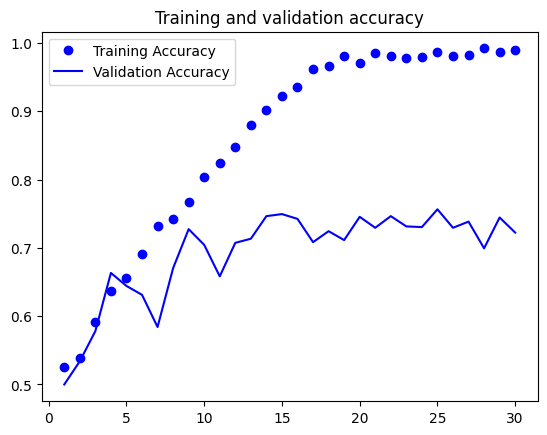

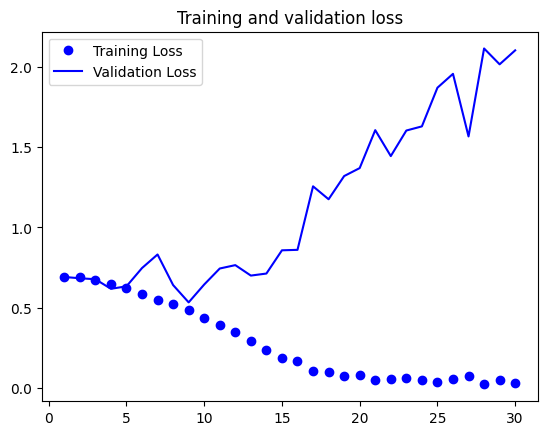

In [54]:
plot_graph(history)

Let’s check the test accuracy. We’ll reload the model from its saved file to evaluate it as it was before it started overfitting.

In [55]:
test_model = tf.keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_accuracy = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.3f}")

63/63 [==============================] - 9s 135ms/step - loss: 0.5292 - accuracy: 0.7392
Test accuracy: 0.739


### Tackle Overfitting with Data Augmentation

 * done by adding a number of data augmentation layers at the start of your model
 * include it right before the Rescaling layer.
 * RandomFlip("horizontal")  -> Applies horizontal flipping to a random 50% of the images that go through it.
 * RandomRotation(0.1) -> Rotates the input images by a random value in the range [–10%, +10%] (these are fractions of a full circle—in degrees, the range would be [–36 degrees, +36 degrees])
 * RandomZoom(0.2)  -> Zooms in or out of the image by a random factor in the range [-20%, +20%]

In [17]:
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

Check few augmented images

 * take(N) to only sample N batches from the dataset. This is equivalent to inserting a break in the loop after the N th batch.
 *  Apply the augmentation stage to the batch of images.
 *  Display the first image in the output batch. For each of the nine iterations, this is a different augmentation of the same image

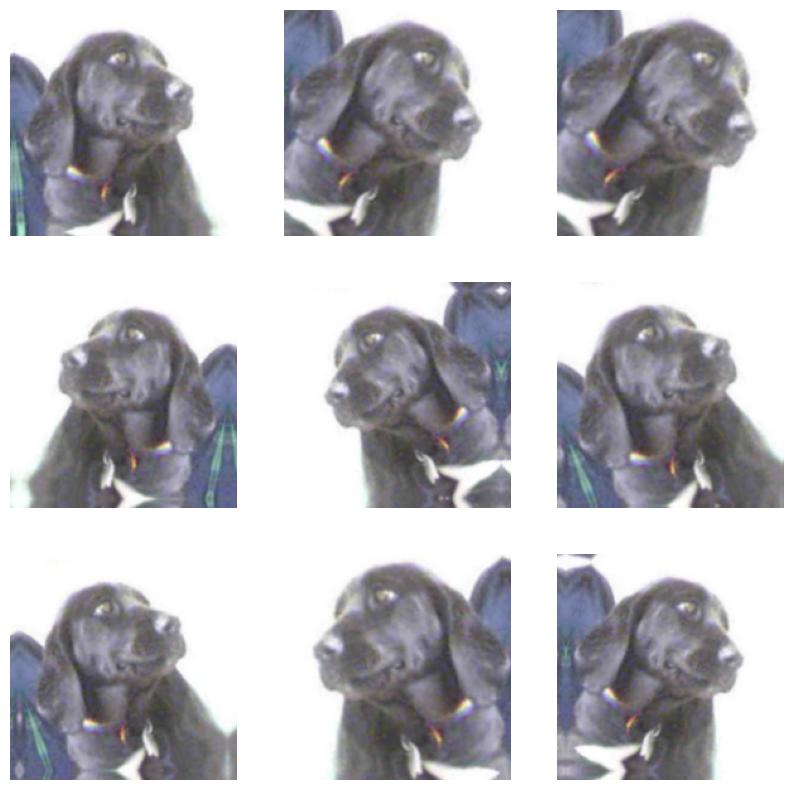

In [46]:
plt.figure(figsize=(10,10))

for images,_ in train_dataset.take(1):  # first batch
    for i in range(9):                 # num must be an integer with 1 <= num <= 9, not 10  (numrow * numcol)
        augemented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augemented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Defining a new convnet that includes image augmentation and dropout

In [50]:
inputs = keras.Input(shape= (180,180,3))
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./255)(x)
x = tf.keras.layers.Conv2D(filters= 32, kernel_size= 3, activation= tf.nn.relu)(x)
x = tf.keras.layers.MaxPool2D(pool_size= 2)(x)
x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, activation= tf.nn.relu)(x)
x = tf.keras.layers.MaxPool2D(pool_size= 2)(x)
x = tf.keras.layers.Conv2D(filters= 128, kernel_size= 3, activation= tf.nn.relu)(x)
x = tf.keras.layers.MaxPool2D(pool_size= 2)(x)
x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, activation= tf.nn.relu)(x)
x = tf.keras.layers.MaxPool2D(pool_size= 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(units=1, activation= tf.nn.sigmoid)(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [56]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch_with_augmentation.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]
history = model.fit(
        train_dataset,
        epochs=100,
        validation_data= validation_dataset,
        callbacks= callbacks)

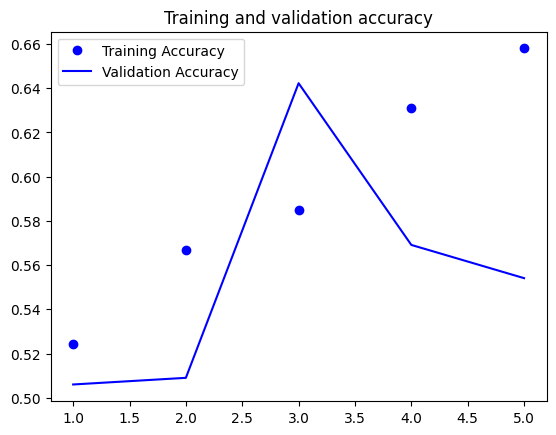

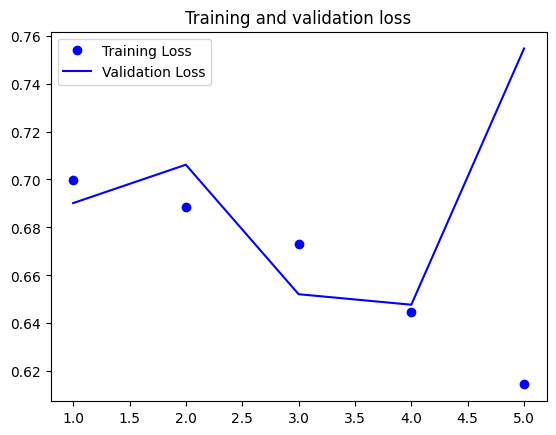

In [57]:
plot_graph(histor)

In [60]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 9s 124ms/step - loss: 0.4293 - accuracy: 0.8093
Test accuracy: 0.809


### Leveraging a pretrained model

Instantiating the VGG16 convolutional base

In [4]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (180,180,3))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION
 * extracting features as NumPy arrays by calling the predict() method of the conv_base model on our training, validation, and testing datasets.
 * predict() only expects images, not labels, but our current dataset yields batches that contain both images and their labels
 * Morever the VGG16 model expects inputs that are preprocessed with the function keras.applications.vgg16.preprocess_input, which scales pixel values to an appropriate range.
 * 

In [18]:
import numpy as np

def get_features_and_labelse(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features , train_labels = get_features_and_labelse(train_dataset)
val_features,  val_labels = get_features_and_labelse(validation_dataset)
test_features, test_labels = get_features_and_labelse(test_dataset)

1/1 [==============================] - 1s 1s/step


In [19]:
 train_features.shape

(2000, 5, 5, 512)

Defining and training the densely connected classifier
* Note the use of the Flatten layer before passing the features to a Dense layer.
* Training is very fast because we only have to deal with two Dense layers—an epoch takes less than one second even on CPU.

In [22]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)               
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
  
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)


Epoch 1/20


63/63 [==============================] - 2s 18ms/step - loss: 20.6230 - accuracy: 0.9265 - val_loss: 6.1756 - val_accuracy: 0.9539
Epoch 2/20
63/63 [==============================] - 1s 12ms/step - loss: 3.5289 - accuracy: 0.9770 - val_loss: 15.2625 - val_accuracy: 0.9198
Epoch 3/20
63/63 [==============================] - 1s 13ms/step - loss: 2.9994 - accuracy: 0.9840 - val_loss: 4.1297 - val_accuracy: 0.9729
Epoch 4/20
63/63 [==============================] - 1s 13ms/step - loss: 1.0666 - accuracy: 0.9885 - val_loss: 4.0924 - val_accuracy: 0.9749
Epoch 5/20
63/63 [==============================] - 1s 12ms/step - loss: 0.9393 - accuracy: 0.9900 - val_loss: 5.8905 - val_accuracy: 0.9699
Epoch 6/20
63/63 [==============================] - 1s 13ms/step - loss: 1.3660 - accuracy: 0.9925 - val_loss: 4.7509 - val_accuracy: 0.9729
Epoch 7/20
63/63 [==============================] - 1s 13ms/step - loss: 1.1587 - accuracy: 0.9915 - val_loss: 5.9021 - val_accuracy: 0.9729
Epoch 8/

Plotting the results 
* validation accuracy of about 97%
* the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate
* Overfitting happens because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

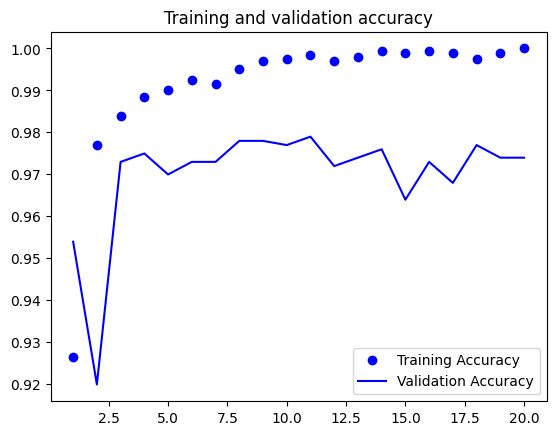

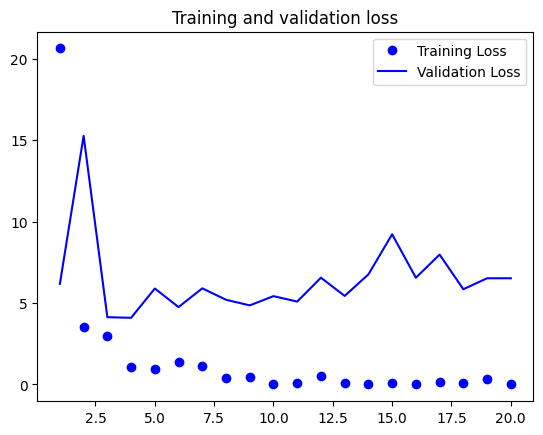

In [24]:
plot_graph(history)

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION
* allows us to use data augmentation during training:
* creating a model that chains the conv_base with a new dense classifier, and training it end to end on the inputs
* In order to do this, we will first freeze the convolutional base
* Freezing a layer or set of layers means preventing their weights from being updated during training
  * In Keras, we freeze a layer or model by setting its trainable attribute to False
  * Setting trainable to False empties the list of trainable weights of the layer or model. 

Instantiating and freezing the VGG16 convolutional base

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights= "imagenet",
    include_top = False,
    conv_base.trainable = False
)

Printing the list of trainable weights before and after freezing

In [26]:
conv_base.trainable = True
print("This is the number of trainable weights " 
          "before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights " 
          "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


### tf.data.Dataset
 * .batch(size)
 * .shuffle(buffer_size)
 * .prefetch(buffer_size)
 * .map(callable function )

In [34]:
import numpy as np 
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)  

In [37]:
random_numbers.shape

(1000, 16)

At first, our dataset just yields single samples:

In [29]:
for i, element in enumerate(dataset):
     print(element.shape)
     if i >= 2:
         break

(16,)
(16,)
(16,)


We can use the .batch() method to batch the data:

In [40]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i>=2:
        break

(32, 16)
(32, 16)
(32, 16)


.map() example
 * We’ll use it to reshape the elements in our toy dataset from shape (16,) to shape (4, 4)

In [44]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4,4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i>=2:
        break                            

(4, 4)
(4, 4)
(4, 4)


### Basics revisited

In [ ]:
x = tf.constant([[1., 1.], [2., 2.]])
tf.reduce_mean(x)

<tf.Tensor: shape=(), dtype=float32, numpy=1.5>

In [ ]:
t = tf.constant([[[1, 1, 1], [2, 2, 2]], [[3, 3, 3], [4, 4, 4]]])
print(tf.shape(t))

tf.Tensor([2 2 3], shape=(3,), dtype=int32)


In [ ]:
t = [[1, 2, 3,-1,-10],
     [4, 5, 6,-2,-20],
     [7,8,9,-4,-40]]
print(tf.reshape(t,[-1,3]))

tf.Tensor(
[[  1   2   3]
 [ -1 -10   4]
 [  5   6  -2]
 [-20   7   8]
 [  9  -4 -40]], shape=(5, 3), dtype=int32)


In [ ]:
print(_)

tf.Tensor(1.5, shape=(), dtype=float32)


#Preprocess

For convenience, set up variables to use while pre-processing the dataset and training the network.

In [ ]:
batch_size = 32
epochs = 30
IMG_HEIGHT = 180
IMG_WIDTH = 180

**Data** **preparation**
Format the images into appropriately pre-processed floating point tensors before feeding to the network:

In [13]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the flow_from_directory method load images from the disk, applies rescaling, and resizes the images into the required dimensions

In [ ]:
train_image_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(directory= validation_dir,batch_size=batch_size,
                                                              target_size = (IMG_HEIGHT,IMG_WIDTH),
                                                              shuffle =True,
                                                              class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)